---
title: "Snowflake Storage Cortex Forecast Example"
date: "08/25/2024"
format:
    html:
        code-fold: False
        output: False
---

# Overview

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| hide
from nbdev.showdoc import *

# Example Useage

In [3]:
#| skip
from snowflake.snowpark.version import VERSION
from cortex_forecast.forecast import SnowflakeMLForecast
import os

In [20]:
#| skip
forecast_model = SnowflakeMLForecast(
    config_file='./cortex_forecast/files/yaml/storage_forecast_config.yaml',
    connection_config={
        'user': os.getenv('SNOWFLAKE_USER'),
        'password': os.getenv('SNOWFLAKE_PASSWORD'),
        'account': os.getenv('SNOWFLAKE_ACCOUNT'),
        'database': 'CORTEX',
        'warehouse': 'CORTEX_WH',
        'schema': 'DEV',
        'role': 'CORTEX_USER_ROLE'  # Use the desired role
    },
    is_streamlit=False
)

snowflake_environment = forecast_model.session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(forecast_model.session.get_current_role()))
print('Database                    : {}'.format(forecast_model.session.get_current_database()))
print('Schema                      : {}'.format(forecast_model.session.get_current_schema()))
print('Warehouse                   : {}'.format(forecast_model.session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0], snowpark_version[1], snowpark_version[2]))



Connection Established with the following parameters:
User                        : JD_SERVICE_ACCOUNT_ADMIN
Role                        : "CORTEX_USER_ROLE"
Database                    : "CORTEX"
Schema                      : "DEV"
Warehouse                   : "CORTEX_WH"
Snowflake version           : 8.33.0
Snowpark for Python version : 1.19.0


In [10]:
#| skip
# Create Training Data
training_days = 365
predicted_days = 30

forecast_model.session.sql(f'''CREATE OR REPLACE TABLE storage_usage_train AS
    SELECT 
        TO_TIMESTAMP_NTZ(usage_date) AS usage_date,
        storage_bytes / POWER(1024, 3) AS storage_gb
    FROM 
    (
        SELECT * 
            FROM snowflake.account_usage.storage_usage
            WHERE usage_date < CURRENT_DATE()
    )
    WHERE TO_TIMESTAMP_NTZ(usage_date) > DATEADD(day, -{training_days}, CURRENT_DATE())
''').collect()
forecast_model.session.sql('SELECT * FROM storage_usage_train ORDER BY usage_date DESC LIMIT 10').show()

--------------------------------------------
|"USAGE_DATE"         |"STORAGE_GB"        |
--------------------------------------------
|2024-09-05 00:00:00  |279.8410659143701   |
|2024-09-04 00:00:00  |273.75833379570395  |
|2024-09-03 00:00:00  |267.7940624393523   |
|2024-09-02 00:00:00  |265.5218228260055   |
|2024-09-01 00:00:00  |265.05640272889286  |
|2024-08-31 00:00:00  |265.0566206406802   |
|2024-08-30 00:00:00  |265.0504933735356   |
|2024-08-29 00:00:00  |265.32130791060627  |
|2024-08-28 00:00:00  |265.77701564040035  |
|2024-08-27 00:00:00  |267.33904562331736  |
--------------------------------------------



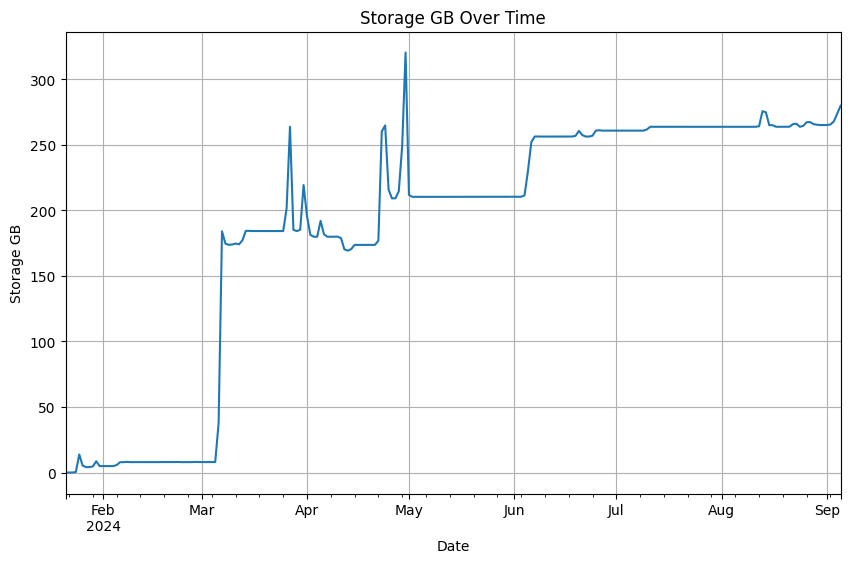

In [11]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

df = forecast_model.session.sql('SELECT * FROM storage_usage_train ORDER BY usage_date').to_pandas()
df.head()
df = df.set_index('USAGE_DATE')
df['STORAGE_GB'].plot(figsize=(10, 6), title='Storage GB Over Time')

# Show the plot
plt.xlabel('Date')
plt.ylabel('Storage GB')
plt.grid(True)
plt.show()


In [18]:
# Run Forecast
forecast_data = forecast_model.create_and_run_forecast()
forecast_data.head()

Attempting to create tag: environment
Tag 'environment' already exists.
Attempting to create tag: team
Tag 'team' already exists.
Step 1/4: Creating training table...
Generated SQL:

        CREATE OR REPLACE TEMPORARY TABLE my_forecast_model_20240906_ikpea_train AS
        SELECT TO_TIMESTAMP_NTZ(usage_date) AS usage_date, storage_gb AS storage_gb, * EXCLUDE (usage_date, storage_gb)
        FROM storage_usage_train
        
            WHERE TO_TIMESTAMP_NTZ(usage_date) 
            BETWEEN 
            DATEADD(day, -365, (SELECT MAX(usage_date) FROM storage_usage_train)) 
            AND 
            (SELECT MAX(usage_date) FROM storage_usage_train)
            ;
Step 2/4: Creating forecast model...
Generated SQL:

        CREATE OR REPLACE SNOWFLAKE.ML.FORECAST my_forecast_model_20240906_ikpea(
            INPUT_DATA => SYSTEM$REFERENCE('table', 'my_forecast_model_20240906_ikpea_train'),
            TIMESTAMP_COLNAME => 'usage_date',
            TARGET_COLNAME => 'storage_gb',
     

,USAGE_DATE,FORECAST,LOWER_BOUND,UPPER_BOUND
0,2024-09-06,279.628776,277.026308,282.231245
1,2024-09-07,278.653023,274.972576,282.333469
2,2024-09-08,278.725210,274.217602,283.232819
3,2024-09-09,278.646488,273.441550,283.851426
4,2024-09-10,277.903107,272.083810,283.722405


In [19]:
forecast_model.generate_forecast_and_visualization(show_historical=True)

Executing forecast query:

            SELECT *
            FROM storage_forecast_results
            ORDER BY USAGE_DATE
        
Forecast data preview:


,USAGE_DATE,FORECAST,LOWER_BOUND,UPPER_BOUND
0,2024-09-06,279.628776,277.026308,282.231245
1,2024-09-07,278.653023,274.972576,282.333469
2,2024-09-08,278.725210,274.217602,283.232819
3,2024-09-09,278.646488,273.441550,283.851426
4,2024-09-10,277.903107,272.083810,283.722405


Executing historic actuals query:

        SELECT usage_date, storage_gb
        FROM storage_usage_train
        ORDER BY usage_date
        
Historical data preview:


,USAGE_DATE,STORAGE_GB
0,2024-01-21,0.000000
1,2024-01-22,0.000000
2,2024-01-23,0.000002
3,2024-01-24,0.415556
4,2024-01-25,13.761164


Getting historical max date
Max historical date: 2024-09-05 00:00:00
KeyError encountered: "The following id_vars or value_vars are not present in the DataFrame: ['ts', 'forecast']"
Top 10 Feature Importances


alt.Chart(...)

,RANK,FEATURE_NAME,SCORE,FEATURE_TYPE
0,1,lag7,0.10,derived_from_endogenous
1,2,aggregated_endogenous_trend_features,0.09,derived_from_endogenous
2,3,lag14,0.08,derived_from_endogenous
3,4,lag28,0.08,derived_from_endogenous
4,5,lag91,0.06,derived_from_endogenous
5,6,lag63,0.06,derived_from_endogenous
6,7,lag98,0.05,derived_from_endogenous
7,8,lag84,0.05,derived_from_endogenous
8,9,lag21,0.05,derived_from_endogenous
9,10,lag35,0.05,derived_from_endogenous


Underlying Model Metrics


,ERROR_METRIC,METRIC_VALUE,STANDARD_DEVIATION,LOGS
0,MAE,5.449,1.350,None
1,MAPE,0.020,0.005,None
2,MDA,0.667,0.067,None
3,MSE,49.907,4.074,None
4,SMAPE,0.020,0.005,None
5,COVERAGE_INTERVAL=0.95,0.977,0.032,None
6,WINKLER_ALPHA=0.05,55.907,37.697,None


In [40]:
#| skip
from snowflake.snowpark.version import VERSION
from cortex_forecast.forecast import SnowflakeMLForecast
import os

In [41]:
#| skip
forecast_model = SnowflakeMLForecast(
    config_file='./cortex_forecast/files/yaml/storage_forecast_config.yaml',
    connection_config={
        'user': os.getenv('SNOWFLAKE_USER'),
        'password': os.getenv('SNOWFLAKE_PASSWORD'),
        'account': os.getenv('SNOWFLAKE_ACCOUNT'),
        'database': 'CORTEX',
        'warehouse': 'CORTEX_WH',
        'schema': 'DEV',
        'role': 'CORTEX_USER_ROLE'  # Use the desired role
    },
    is_streamlit=False
)

snowflake_environment = forecast_model.session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(forecast_model.session.get_current_role()))
print('Database                    : {}'.format(forecast_model.session.get_current_database()))
print('Schema                      : {}'.format(forecast_model.session.get_current_schema()))
print('Warehouse                   : {}'.format(forecast_model.session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0], snowpark_version[1], snowpark_version[2]))


# Run Forecast
forecast_data = forecast_model.create_and_run_forecast()
forecast_data.head()




Connection Established with the following parameters:
User                        : JD_SERVICE_ACCOUNT_ADMIN
Role                        : "CORTEX_USER_ROLE"
Database                    : "CORTEX"
Schema                      : "DEV"
Warehouse                   : "CORTEX_WH"
Snowflake version           : 8.33.1
Snowpark for Python version : 1.19.0
Attempting to create tag: environment
Tag 'environment' already exists.
Attempting to create tag: team
Tag 'team' already exists.
Step 1/4: Creating training table...
Generated SQL:

        CREATE OR REPLACE TEMPORARY TABLE my_forecast_model_20240906_hzbos_train AS
        SELECT TO_TIMESTAMP_NTZ(usage_date) AS usage_date, storage_gb AS storage_gb, * EXCLUDE (usage_date, storage_gb)
        FROM storage_usage_train
        
            WHERE TO_TIMESTAMP_NTZ(usage_date) 
            BETWEEN 
            DATEADD(day, -365, (SELECT MAX(usage_date) FROM storage_usage_train)) 
            AND 
            (SELECT MAX(usage_date) FROM storage_usa

,USAGE_DATE,FORECAST,LOWER_BOUND,UPPER_BOUND,MODEL_NAME,CREATION_DATE,MODEL_COMMENT
0,2024-09-06,279.628776,277.026308,282.231245,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.
1,2024-09-07,278.653023,274.972576,282.333469,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.
2,2024-09-08,278.725210,274.217602,283.232819,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.
3,2024-09-09,278.646488,273.441550,283.851426,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.
4,2024-09-10,277.903107,272.083810,283.722405,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.


In [42]:
# Generate Forecast and Visualization
forecasting_period = 30
confidence_interval = 0.95
forecast_model.generate_forecast_and_visualization(show_historical=True)

Executing forecast query:

            SELECT *
            FROM storage_forecast_results
            WHERE model_name = 'my_forecast_model_20240906_hzbos'
            ORDER BY usage_date DESC
        
Forecast data preview (last 5 rows):


,USAGE_DATE,FORECAST,LOWER_BOUND,UPPER_BOUND,MODEL_NAME,CREATION_DATE,MODEL_COMMENT
25,2024-09-10,277.903107,272.083810,283.722405,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.
26,2024-09-09,278.646488,273.441550,283.851426,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.
27,2024-09-08,278.725210,274.217602,283.232819,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.
28,2024-09-07,278.653023,274.972576,282.333469,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.
29,2024-09-06,279.628776,277.026308,282.231245,my_forecast_model_20240906_hzbos,2024-09-06 13:53:51.099000-07:00,Forecast model for predicting sales trends.


Executing historic actuals query:

            SELECT usage_date, storage_gb
            FROM storage_usage_train
            ORDER BY usage_date DESC
            LIMIT 21
            
Historical data preview (last 5 rows):


,USAGE_DATE,STORAGE_GB
16,2024-08-20,263.743386
17,2024-08-19,263.740114
18,2024-08-18,263.736670
19,2024-08-17,263.737937
20,2024-08-16,264.926883


Getting historical max date
Max historical date: 2024-09-05 00:00:00
Combined data preview (last 5 rows):


,USAGE_DATE,TYPE,VALUE_TYPE,VOLUME
127,2024-09-10,Forecast,UPPER_BOUND,283.722405
128,2024-09-09,Forecast,UPPER_BOUND,283.851426
129,2024-09-08,Forecast,UPPER_BOUND,283.232819
130,2024-09-07,Forecast,UPPER_BOUND,282.333469
131,2024-09-06,Forecast,UPPER_BOUND,282.231245


alt.LayerChart(...)

Top 10 Feature Importances


alt.Chart(...)

,SERIES,RANK,FEATURE_NAME,SCORE,FEATURE_TYPE
0,None,1,lag7,0.10,derived_from_endogenous
1,None,2,aggregated_endogenous_trend_features,0.09,derived_from_endogenous
2,None,3,lag14,0.08,derived_from_endogenous
3,None,4,lag28,0.08,derived_from_endogenous
4,None,5,lag91,0.06,derived_from_endogenous
5,None,6,lag63,0.06,derived_from_endogenous
10,None,11,lag42,0.05,derived_from_endogenous
13,None,14,lag77,0.05,derived_from_endogenous
12,None,13,lag56,0.05,derived_from_endogenous
11,None,12,lag49,0.05,derived_from_endogenous


Underlying Model Metrics


,SERIES,ERROR_METRIC,METRIC_VALUE,STANDARD_DEVIATION,LOGS
0,None,MAE,5.449,1.350,None
1,None,MAPE,0.020,0.005,None
2,None,MDA,0.667,0.067,None
3,None,MSE,49.907,4.074,None
4,None,SMAPE,0.020,0.005,None
5,None,COVERAGE_INTERVAL=0.95,0.977,0.032,None
6,None,WINKLER_ALPHA=0.05,55.907,37.697,None


In [ ]:
# Generate Forecast and Visualization
forecasting_period = 30
confidence_interval = 0.95
forecast_model.generate_forecast_and_visualization(show_historical=False)

Executing forecast query:

            SELECT *
            FROM storage_forecast_results
            WHERE model_name =  'my_forecast_model_20240906_dhzae'
            ORDER BY usage_date DESC
        
Forecast data preview (last 5 rows):


,MODEL_NAME,CREATION_DATE,USAGE_DATE,FORECAST,LOWER_BOUND,UPPER_BOUND
25,my_forecast_model_20240906_dhzae,2024-09-06 13:24:26.088000-07:00,2024-09-10,277.903107,272.083810,283.722405
26,my_forecast_model_20240906_dhzae,2024-09-06 13:24:26.088000-07:00,2024-09-09,278.646488,273.441550,283.851426
27,my_forecast_model_20240906_dhzae,2024-09-06 13:24:26.088000-07:00,2024-09-08,278.725210,274.217602,283.232819
28,my_forecast_model_20240906_dhzae,2024-09-06 13:24:26.088000-07:00,2024-09-07,278.653023,274.972576,282.333469
29,my_forecast_model_20240906_dhzae,2024-09-06 13:24:26.088000-07:00,2024-09-06,279.628776,277.026308,282.231245


Executing historic actuals query:

            SELECT usage_date, storage_gb
            FROM storage_usage_train
            ORDER BY usage_date DESC
            LIMIT 21
            
Historical data preview (last 5 rows):


,USAGE_DATE,STORAGE_GB
16,2024-08-20,263.743386
17,2024-08-19,263.740114
18,2024-08-18,263.736670
19,2024-08-17,263.737937
20,2024-08-16,264.926883


Getting historical max date
Max historical date: 2024-09-05 00:00:00
Combined data preview (last 5 rows):


,USAGE_DATE,TYPE,VALUE_TYPE,VOLUME
85,2024-09-10,Forecast,UPPER_BOUND,283.722405
86,2024-09-09,Forecast,UPPER_BOUND,283.851426
87,2024-09-08,Forecast,UPPER_BOUND,283.232819
88,2024-09-07,Forecast,UPPER_BOUND,282.333469
89,2024-09-06,Forecast,UPPER_BOUND,282.231245


alt.LayerChart(...)

Top 10 Feature Importances


alt.Chart(...)

,RANK,FEATURE_NAME,SCORE,FEATURE_TYPE
0,1,lag7,0.10,derived_from_endogenous
1,2,aggregated_endogenous_trend_features,0.09,derived_from_endogenous
2,3,lag14,0.08,derived_from_endogenous
3,4,lag28,0.08,derived_from_endogenous
4,5,lag91,0.06,derived_from_endogenous
5,6,lag63,0.06,derived_from_endogenous
6,7,lag98,0.05,derived_from_endogenous
7,8,lag84,0.05,derived_from_endogenous
8,9,lag21,0.05,derived_from_endogenous
9,10,lag35,0.05,derived_from_endogenous


Underlying Model Metrics


,ERROR_METRIC,METRIC_VALUE,STANDARD_DEVIATION,LOGS
0,MAE,5.449,1.350,None
1,MAPE,0.020,0.005,None
2,MDA,0.667,0.067,None
3,MSE,49.907,4.074,None
4,SMAPE,0.020,0.005,None
5,COVERAGE_INTERVAL=0.95,0.977,0.032,None
6,WINKLER_ALPHA=0.05,55.907,37.697,None
